# Исследование рынка заведений общественного питания <a name="0"></a>

Исследование проводится для рынка Москвы. Проект — роботизированное кафе, аналогов которого на данный момент на рынке  нет. Цель исследования — выявить перспективные форматы заведений общественного питания и дать рекомендации, которые помогут принять бизнес-решение о запуске нового проекта.  

____
### Оглавление

#### [Часть 1. Первичное изучение полученных данных](#1)

   [1.1 Загрузка библиотек и файлов с данными](#1.1)  
   [1.2 Изучение основных параметров датафрейма](#1.2)  
   [1.3 Выводы: описание полученных данных](#1.3)   

#### [Часть 2. Исследовательский анализ данных](#2)

   [2.1 Оценка объектов общественного питания и их разделения по сетевому признаку](#2.1)  
   [2.2 Анализ количества посадочных мест для разных типов заведений](#2.2)  
   [2.3 Анализ расположения объектов в Москве и поиск популярных районов](#2.3)  
       — [парсинг дополнительных данных через API Яндекс.Карт: описание и код](#2.3.1)    
       — [объединение данных и анализ географии рынка общественного питания в Москве](#2.3.2)  
   [2.4 Анализ загруженности улиц объектами общественного питания](#2.4)   
   [2.5 Выводы: итоги подготовки данных к анализу](#2.5)    

#### [Часть 3. Итоговые выводы исследования](#3)
____

# Часть 1. Первичное изучение полученных данных <a name='1'></a>

### 1.1 Загрузка библиотек и файлов с данными <a name='1.1'></a>

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

# дефолтные параметры отображения графиков plotly
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
pio.renderers.default = "svg"

# для парсинга доп.информации
import requests
import json

# увеличим ширину колонок
pd.set_option('max_colwidth', 120)

In [2]:
# загрузка файла с данными
rest_data = pd.read_csv('/datasets/8_rest_data.csv')

### 1.2 Изучение основных параметров датафрейма <a name='1.2'></a>

In [3]:
# функция для изучения основных параметров датафрейма
def df_info(data):
    print("\033[1m\033[34mПервые строки таблицы:\033[0m")
    display(data.head(3))
    print("\033[1m\033[34mОбщая информация о данных в таблице:\033[0m")
    display(data.info())
    print("\033[1m\033[34mКоличество дубликатов:\033[0m {}".format(data.duplicated().sum()))

In [4]:
# применим функцию и изучим данные в таблице
df_info(rest_data)

Первые строки таблицы:


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95


Общая информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

Количество дубликатов: 0


In [5]:
# поиск скрытых дубликатов
(rest_data[rest_data.duplicated(subset=['object_name', 'object_type', 'chain', 'address', 'number'], keep=False)]
 .sort_values(by=['object_name', 'address'])
 .head(10)
)

,id,object_name,chain,object_type,address,number
2869,25031,LALTRO BOSCO,нет,ресторан,"город Москва, улица Петровка, дом 10",145
13858,209723,LALTRO BOSCO,нет,ресторан,"город Москва, улица Петровка, дом 10",145
5058,20019,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",20
5059,20021,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 1",20
5067,20023,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 3",10
5069,20025,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, корпус 3",10
14843,219509,Sushi-Make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
14844,219518,Sushi-Make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
5761,134323,Алекс,нет,кафе,"город Москва, Тихорецкий бульвар, владение 1, строение 2",45
5762,134324,Алекс,нет,кафе,"город Москва, Тихорецкий бульвар, владение 1, строение 2",45


In [6]:
print("\033[1m\033[34mКоличество дубликатов:\033[0m {}"
      .format(rest_data.duplicated(subset=['object_name', 'object_type', 'chain', 'address', 'number'], keep='first')
              .sum()))

Количество дубликатов: 82


Если исключить колонку `id`, то дубликаты составят ~0,5% данных. Удалим скрытые дубликаты:

In [7]:
rest_data = (rest_data
             .drop_duplicates(subset=['object_name', 'object_type', 'chain', 'address', 'number'])
             .reset_index(drop=True))

### 1.3 Выводы: описание полученных данных <a name='1.3'></a>

Таблица `rest_data` хранит иформацию о 10393 заведениях общественного питания Москвы.  
В таблице 6 колонок: 
* `id` — идентификатор объекта (тип данных `int64`)   
* `object_name` — название объекта общественного питания (тип данных `object`)  
* `chain` — сетевой ресторан (тип данных `object`)  
* `object_type` — тип объекта общественного питания (тип данных `object`)  
* `address` — адрес (тип данных `object`)   
* `number` — количество посадочных мест (тип данных `int64`)  
  
**Дубликатов, пропусков и проблем с типами данных в датафрейме не обнаружено.**

# Часть 2. Исследовательский анализ данных <a name='2'></a>

### 2.1 Оценка объектов общественного питания и их разделения по сетевому признаку <a name='2.1'></a>

Исследуем данные и выделим доли заведений по видам (кафе/ресторан/и тд.), а также выделим сетевые и несетевые заведения, выясним какие встречаются чаще.

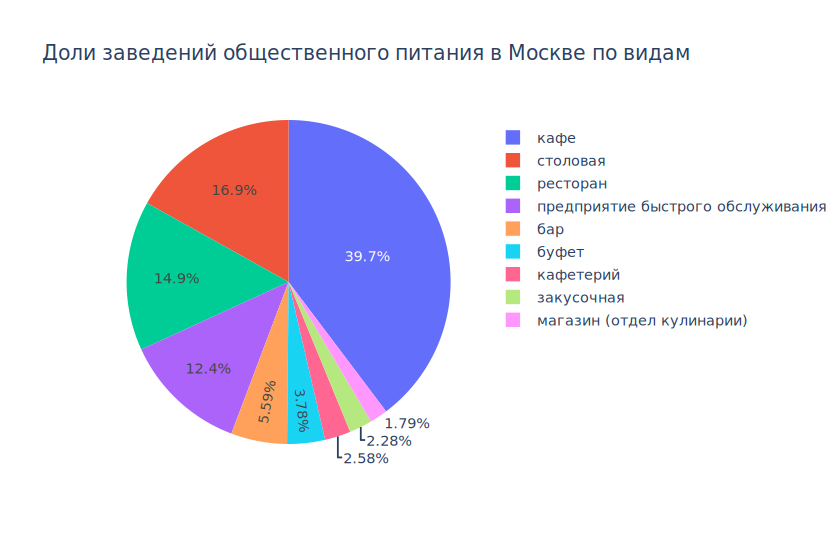

In [8]:
# подготовим данные
type_rest = rest_data.groupby('object_type').agg({'id':'count'}).reset_index()
type_rest.columns = ['rest_type', 'rest_count']

# построим круговую диаграмму по виду заведений
fig_type = go.Figure(data=[go.Pie(labels=type_rest['rest_type'], values=type_rest['rest_count'])])
fig_type.update_layout(title='Доли заведений общественного питания в Москве по видам')
fig_type.show()

In [9]:
# разделим объекты по сетевому признаку
chain_rest = rest_data.groupby(['chain', 'object_type']).agg({'id':'count'}).reset_index()
chain_rest.columns = ['chain', 'rest_type', 'rest_count']

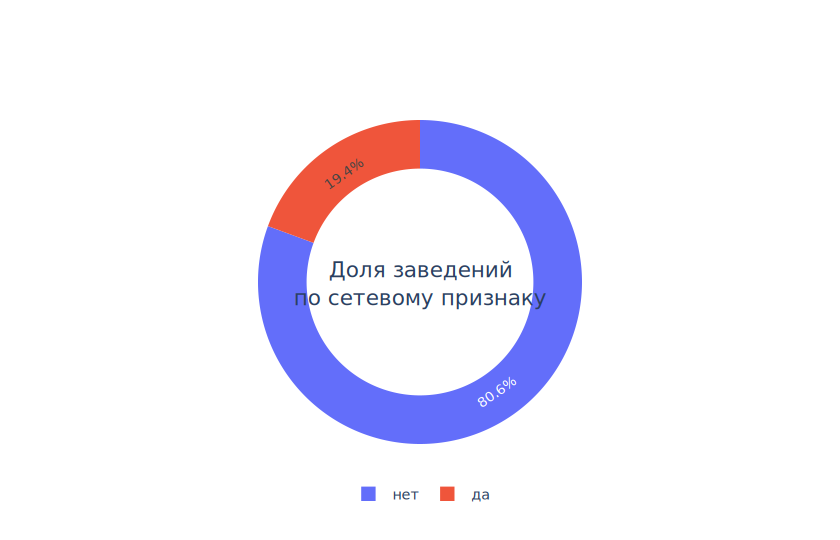

In [10]:
# построим круговую диаграмму
labels = chain_rest['chain']
values = chain_rest['rest_count']

fig_chain = go.Figure(go.Pie(
    labels = labels,
    values=values, 
    hole=0.7
))

fig_chain.update_layout(
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"), 
    annotations=[dict(text='Доля заведений<br>по сетевому признаку', x=0.5, y=0.5, font_size=18, showarrow=False)])

fig_chain.show()

In [11]:
# изучим популярные виды заведений в зависимости от сетевого признака
chain = (chain_rest[chain_rest['chain'] == 'да'][['rest_type', 'rest_count']]
         .merge(chain_rest[chain_rest['chain'] == 'нет'][['rest_type', 'rest_count']], 
                on='rest_type', suffixes=['_yes', '_no']))

In [12]:
# расчитаем долю сетевых заведений 
chain['chain_yes_part'] = chain['rest_count_yes'] / (chain['rest_count_yes'] + chain['rest_count_no'])
chain['chain_no_part'] = chain['rest_count_no'] / (chain['rest_count_yes'] + chain['rest_count_no'])
chain

,rest_type,rest_count_yes,rest_count_no,chain_yes_part,chain_no_part
0,бар,37,818,0.043275,0.956725
1,буфет,11,566,0.019064,0.980936
2,закусочная,56,293,0.160458,0.839542
3,кафе,1396,4675,0.229946,0.770054
4,кафетерий,52,343,0.131646,0.868354
5,магазин (отдел кулинарии),78,195,0.285714,0.714286
6,предприятие быстрого обслуживания,788,1110,0.415174,0.584826
7,ресторан,543,1739,0.237949,0.762051
8,столовая,3,2581,0.001161,0.998839


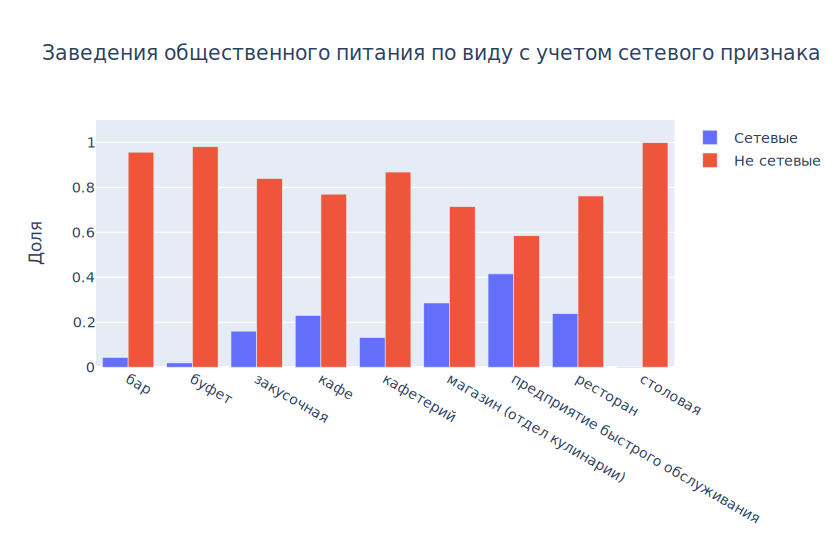

In [13]:
# построем столбчатый график
fig_chain_type = go.Figure(
    data=[
        go.Bar(
            name="Сетевые",
            x=chain["rest_type"],
            y=chain['chain_yes_part'],
            offsetgroup=0
        ),
        go.Bar(
            name="Не сетевые",
            x=chain["rest_type"],
            y=chain['chain_no_part'],
            offsetgroup=1
        ),
    ],
    layout=go.Layout(
        title="Заведения общественного питания по виду с учетом сетевого признака",
        yaxis_title="Доля",
        
    )
)

fig_chain_type.update_yaxes(range=[0, 1.1])
fig_chain_type.show()

Предварительное изучение данных показало, что наиболее популярные на рынке заведений общественного питания в Москве виды:  
* кафе — 39.7%  
* столовая — 16.8%  
* ресторан — 14.9%  
* предприятие быстрого обслуживания — 12.5%  
  
При этом сетевые заведения занимают всего лишь 19.3% рынка. При этом есть некоторое отличие в топ-3 видов заведений для сетевых и несетевых заведений, которые видны на последнем графике. Для несетевых заведений характерны все представленные виды ресторанов. Этот формат наиболее привычен для столовых, буфетов, баров, кафетериев и закусочных, а для сетевых чаще встречается формат предприятия быстрого питания, отдела при магазине, ресторана и кафе.

**Предварительно можно порекомендовать формат кафе или ресторана для нашего проекта** вне зависимости от планов развивать сеть или ограничиться одним заведением на будущее. Эти форматы позволят масштабироваться при необходимости и учитывают специфику проекта (персонал-роботы). Предприятие быстрого обслуживания — несмотря на распространненый формат выглядит рискованным вариантом, так как сложно гарантировать скорость обслуживания, когда персонал — роботы. Формат кафетерия предполагает самообслуживание и ограничивает масштаб взаимодействия "робот-клиент", формат бара ограничивает целевую аудиторию, буфет и отдел кулинарии ограничивают проект в самостоятельности продвижения (эти виды открываются при других заведенгиях с другими целями — театры, магазины и тп).  

Продолжим изучать рынок и выясним характерные показатели заведений по количеству посадочных мест.

### 2.2 Изучим данные о количестве посадочных мест для разных типов заведений <a name='2.2'></a>

count    2964.000000
mean       52.981107
std        57.152817
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
85%        96.000000
95%       158.850000
99%       275.370000
max       580.000000
Name: number, dtype: float64

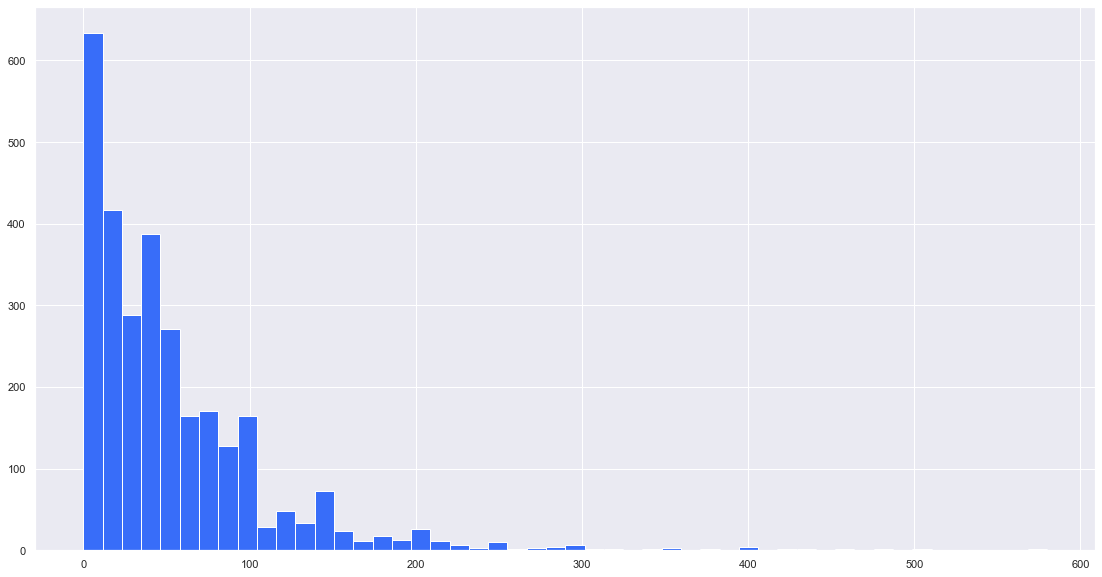

In [14]:
# основные настройки для отображения графиков
sns.set(rc={"figure.figsize":(19, 10)}, font_scale = 1, style="darkgrid", palette="rainbow")

# распределение кол-ва посадочных мест для сетевых заведений
rest_data[rest_data['chain'] == 'да']['number'].hist(bins=50)
display(rest_data[rest_data['chain'] == 'да']['number'].describe(percentiles=[.25, .75, .85, .95, .99]))

count    724.000000
mean       4.093923
std       12.601654
min        1.000000
50%        1.000000
75%        2.000000
95%       12.000000
99%       64.080000
max      155.000000
Name: id, dtype: float64

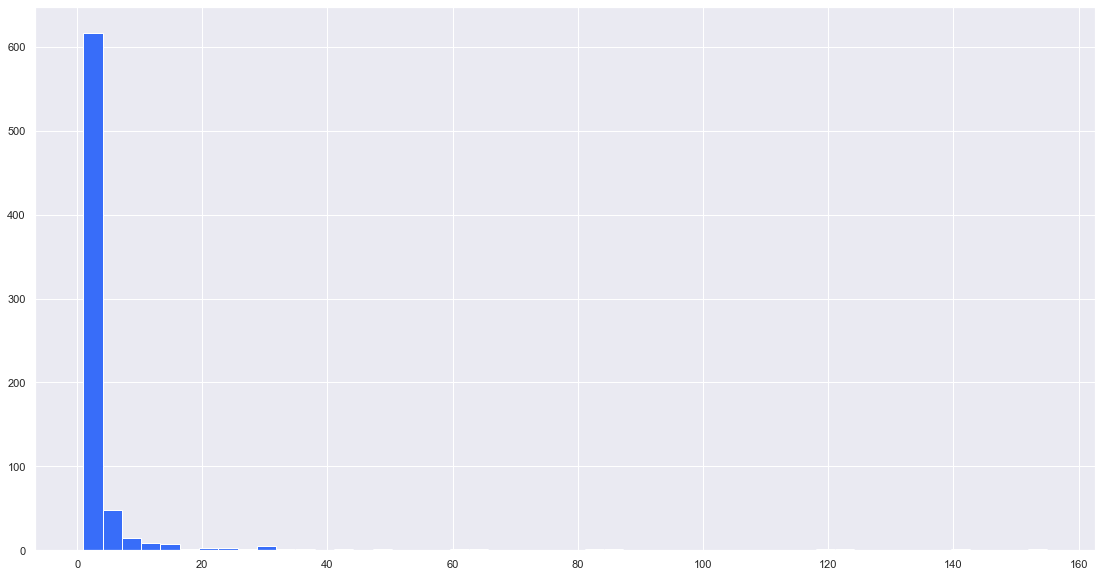

In [15]:
# распределение кол-ва заведений в сети
rest_data[rest_data['chain'] == 'да'].groupby('object_name')['id'].count().hist(bins=50)

(display(rest_data[rest_data['chain'] == 'да']
         .groupby('object_name')['id']
         .count()
         .describe(percentiles=[.75, .95, .99]))
)

По графикам для "сырых" данных по сетевым заведениям можно сделать выводы, что для 85% характерно пространство до 100 посадочних мест, также встречаются сетевые заведения с концепцией "на вынос". В среднем для сетевых заведений характерно 40-50 посадочных мест. При этом в данных большое количество значений с единственным заведением. Для 95% сетей количество объектов не превышает 12 шт.  
  
Для данного исследования будем считать, что сеть — это 2 и более заведений одного бренда, а также уберем из данных объекты-выбросы с 160 и более заведениями в сети (до 5%).

In [16]:
# учтем выбросы и удалим объекты с единственным заведением в сети
norm_chain_rest = (rest_data.query('chain == "да" and number < 160')
                   .groupby('object_name')
                   .agg({'object_type':'max', 'id':'count', 'number':'mean'})
                   .reset_index()
                   .query('id > 1'))

Text(0.5, 0, 'Кол-во посадочных мест')

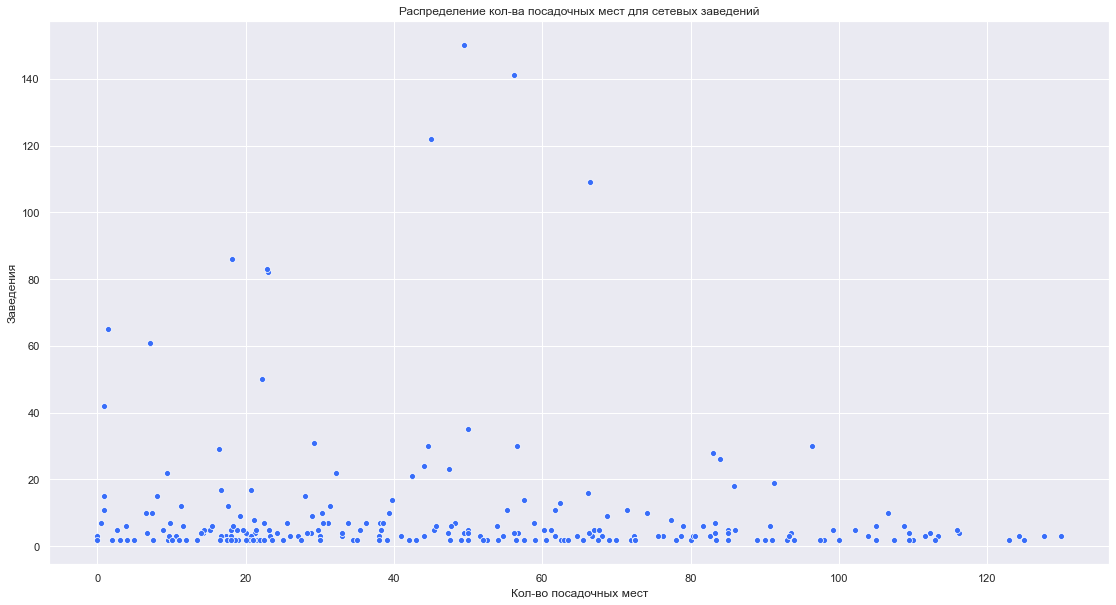

In [17]:
# построим график распределения посадочных мест
ax = sns.scatterplot(y='id', x='number', data=norm_chain_rest)
plt.title('Распределение кол-ва посадочных мест для сетевых заведений')
plt.ylabel('Заведения')
plt.xlabel('Кол-во посадочных мест')

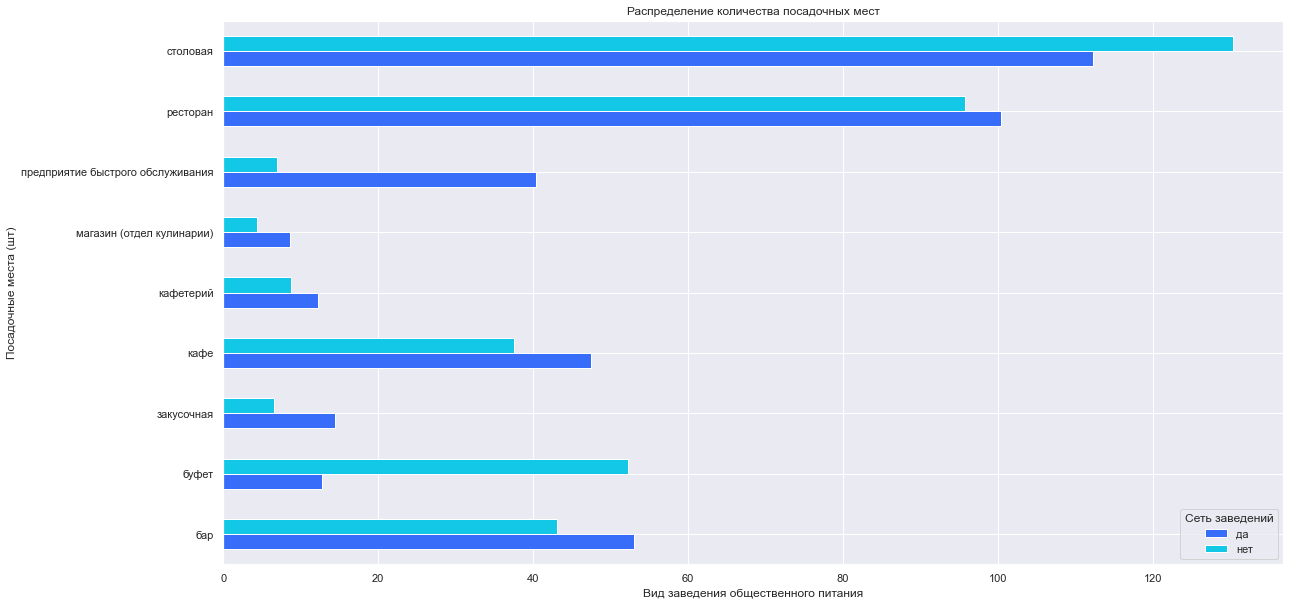

In [18]:
# изучим распределения видов ресторанов по количеству посадочных мест
rest_data.pivot_table(index='object_type', columns='chain', values='number', aggfunc='mean').plot(kind='barh')
plt.title('Распределение количества посадочных мест')
plt.ylabel('Посадочные места (шт)')
plt.xlabel('Вид заведения общественного питания')
plt.legend(title="Сеть заведений")

Ядро сетевых заведений общественного питания в Москве составляют бренды с 2-4 объектами в сети на 10-30 посадочных мест.  
  
При дополнительном разделении сетевых заведений по видам видно, что наибольшее количество посадочных мест характерно для столовых, ресторанов, бары и кафе занимают примерно близкие позиции по этому параметру (кафе уступают по верхней границе). Похожая картина наблюдается для не сетевых заведений, для них так же характерно большое количество выбросов по кол-ву посадочных мест.

Для сетевых заведений характерно небольшое количество объектов в сети (2-4), в которых большой разброс вариантов по посадочным местам, максимально плотное "ядро" наблюдается в районе 10-30 посадочных мест.  
  
Количество посадочных мест в среднем для разных типов заведений отличается для сетевых и несетевых, однако, максимальное количесво одинаково характерно для столовых и ресторанов (более 90 мест)

### 2.3 Анализ расположения объектов в Москве и поиск популярных районов <a name='2.3'></a>

In [19]:
streetname_dict = ['улица','проспект','шоссе','проезд', 'микрорайон', 'линия', 'квартал',
                   'бульвар','переулок','набережная','площадь','вал','аллея']

# функция для поиска названий улиц
def get_street(address):
    for position in [1,0,2]:
        for address_street in address.split(',')[position].split(' '):           
            if address_street in streetname_dict:
                street = address.split(', ')[position]
                return street


rest_data['street'] = rest_data['address'].apply(get_street)
rest_data.head(3)

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица


In [20]:
# функция для поиска номера дома из адреса
def get_house(address):
    for i in address.split(', '):
        if 'дом' in i:
            return i
    
    
rest_data['house'] = rest_data['address'].apply(get_house)
rest_data.head(3)

,id,object_name,chain,object_type,address,number,street,house
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,дом 9
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,дом 2/1
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,дом 6


___
### Парсинг дополнительных данных через API Яндекс.Карт <a name='2.3.1'></a>

Для анализа географического расположения заведений общественного питания и поиска наиболее популярных районов Москвы необходимы дополнительные данные.  
  
**Получить данные о районах по адресу можно черех API Яндекс.Карт в два шага:**  
1. Для каждой улицы найти координаты в формате долгота-широта  
2. По координатам выделить районы Москвы для каждой уникальной улицы  
  
Для запуска кода необходимо [получить ключ для пакета «JavaScript API и HTTP Геокодер»](https://yandex.ru/dev/maps/geocoder/doc/desc/concepts/limits.html/) в кабинете разработчика и подставить его в переменную `API_GEO` в формате `str`. Для получения данных через API в данном случае использовался простой запрос с выдачей результатов в формате `JSON`, [изучить другие запросы можно на странице с примерами](https://yandex.ru/dev/maps/geocoder/doc/desc/examples/geocoder_examples.html/). Ответ API геокодера доступен в следующих форматах `XML`, `JSON` и `JSONP`, [изучить примеры ответов](https://yandex.ru/dev/maps/geocoder/doc/desc/reference/response_structure.html/) также можно на сайте Яндекса.   
  
Для корректной работы кода необходимо импортировать библитеки `requests` и `json`. В решении предусмотрена проверка работоспособности кода на таблице из 4 элементов, которая хранится в `adress_unique_head` — рекомендуется первоначально воспользоваться ей перед применением над всем массивом данных. Ограничение геокодера к количеству бесплатных запросов — 25000 в сутки.  
____

In [ ]:
# датафрейм с уникальными названиями улиц
'''
adress_unique = rest_data.groupby('street', as_index=False).agg({'house':'first'}).reset_index(drop=True)
adress_unique.info()
'''

In [ ]:
# замена пропусков в названиях улиц или номерах домов
'''
adress_unique = adress_unique.fillna('')
'''

In [ ]:
# датафрейм для тестовых запусков кода
'''
adress_unique_head = adress_unique.head(4).copy()
adress_unique_head['street'][0] = '"///kkhgfdx"'
adress_unique_head['house'][0] ='gggg'

adress_unique_head
'''

In [ ]:
# задаем ключевые переменные
'''
API_GEO = 'ваш API-ключ'
BASE_URL = 'https://geocode-maps.yandex.ru/1.x/?apikey=' + API_GEO + '&format=json&geocode='
params = {'city':'Москва'}
'''

Функции рекомендуется использовать для решения заданных узких задач — получение данных о координатах по адресу и данных о районе по координатам, так как они возвращают данные, обращаясь к ответу геокодера в единой последовательности. В случае ошибочного запроса или нестандартного ответа функция вернет значение `'error'`.  
  
При перееиспользовании кода обратите внимание на названия колонок, в которых хранятся данные (пометка в комментариях в коде).

In [ ]:
# функция для получения координат по адресу
# возвращает числовые значения широты и долготы через пробел
'''
def get_coordinate(data):
    # важно: улица в колонке 'street', дом в колонке 'house'
    address = data['street'] + ' ' + data['house']
    URL = BASE_URL + address
    try:
        response = requests.get(url=URL, params=params)
        response_parsed = json.loads(response.text)
        return (response_parsed['response']['GeoObjectCollection']
                ['featureMember'][0]['GeoObject']['Point']['pos'].replace('"', ''))
    except:
        return 'error'
'''

In [ ]:
# функция для получения названий районов по координатам
# возвращает текст
'''
def get_district(data):
    # важно: координаты хранятся в колонке 'coordinate'
    URL = BASE_URL + data['coordinate']
    try:
        response = requests.get(url=URL)
        response_parsed = json.loads(response.text) 
        return (response_parsed['response']['GeoObjectCollection']['featureMember'][2]
                    ['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][5]['name'])
    except:
        return 'error'
'''

**Тестовый запуск на заранее подготовленных данных:** 

In [ ]:
# запускаем функцию поиска координат
# важно: результат сохраняем в колонку 'coordinate'
'''
adress_unique_head['coordinate'] = adress_unique_head.apply(get_coordinate, axis=1)
adress_unique_head
'''

In [ ]:
# запускаем функцию поиска районов по координатам
'''
adress_unique_head['district'] = adress_unique_head.apply(get_district, axis=1)
adress_unique_head
'''

**Работа с основными данными:**

In [ ]:
# парсинг: применим функцию get_coordinate(data)
'''
adress_unique['coordinate'] = adress_unique.apply(get_coordinate, axis=1)
adress_unique.head(3)
'''

In [ ]:
# парсинг: применим функцию get_district(data)
'''
adress_unique['district'] = adress_unique.apply(get_district, axis=1)
adress_unique.head(3)
'''

In [ ]:
# датафрейм с полученными данными
'''
adress_data = adress_unique.query('district != "error"').copy()
adress_data.info()
'''

**Сохраним данные в файл для дальнейшей работы:**  

In [ ]:
'''
adress_data.to_csv('rest_moscow_parsing_results.csv')
'''


____

### Объединение данных и анализ географии рынка общественного питания в Москве <a name='2.3.2'></a>

In [22]:
# словарь улица-район
address_dict = pd.read_csv('rest_moscow_parsing_results.csv').drop(columns=['Unnamed: 0', 'house', 'coordinate'])
address_dict.head(3)

,street,district
0,1-й Автозаводский проезд,Даниловский район
1,1-й Амбулаторный проезд,район Аэропорт
2,1-й Балтийский переулок,район Аэропорт


In [23]:
# изучим пропуски в ключевой таблице
display(rest_data.isnull().sum())
display(rest_data[rest_data['street'].isnull()].groupby('object_name').first().head(3))

id               0
object_name      0
chain            0
object_type      0
address          0
number           0
street         443
house          443
dtype: int64

,id,chain,object_type,address,number,street,house
object_name,,,,,,,
101 вкус,188886,нет,кафе,"город Москва, поселение Щаповское, деревня Троицкое, домовладение 66, корпус 2",16,None,домовладение 66
68. ПАУЗА,149745,нет,бар,"город Москва, город Зеленоград, корпус 1456",48,None,None
BBQ AM Барбекю,200334,нет,предприятие быстрого обслуживания,"город Москва, поселение Московский, деревня Говорово, дом 1Б/Н",20,None,дом 1Б/Н


После применения функции `get_street` в таблице образовалось 445 пропуска, которые частично повлияли на результаты парсинга и пропуски в колонке `district`. Сделав срез данных по пропускам в колонке `street` стало понятно, что часть пропусков связана с некорректным/неполным адресом, который было сложно обработать.  
  
При изучении данных выяснелось, что большая часть пропусков появилась для адресов в небольших населенных пунктах (деревня, посёлок, поселение) и для адресов в городе Зеленоград. Есть гипотеза, что Зеленоград — большая часть пропусков, мы можем выделить его в виде отдельного района, а также проверим город Московский, остальные населенные пункты отметим флагами 'поселение', 'посёлок', 'деревня' — эти населенные пункты не играют значительной роли, так как для нашего проекта необходим большой поток потенциальных посетителей, поэтому ими можно будет пренебречь.

In [24]:
# словарь для Зеленограда и мелких населенных пунктов
other = (rest_data[rest_data['street'].isnull()]
              .drop(columns=['id', 'object_name', 'chain', 'object_type', 'street', 'house', 'number'])
              .copy())

In [25]:
# функция поиска клучевых слов
city = ['Зеленоград', 'Московский', 'поселение', 'посёлок', 'деревня']
def get_city(address):
    for i in address.split(', '):
        for name in city:
            if name in i:
                return i

In [26]:
# проверим количество заведений в Зеленограде
other['district'] = other['address'].apply(get_city)
other.groupby('district').agg({'address':'count'}).sort_values(by='address', ascending=False).head()

,address
district,
город Зеленоград,131
поселение Сосенское,83
поселение Московский,19
поселение Щаповское,16
поселение Рязановское,16


In [27]:
# добавим данные о районе с помощью словарей
rest_geo = rest_data.merge(address_dict, how='left', on='street')

In [28]:
# выделим топ-10 по количеству заведений среди районов Москвы
rest_geo.groupby('district').agg({'id':'count'}).sort_values(by='id', ascending=False).head(10)

,id
district,
Пресненский район,715
Тверской район,711
Басманный район,415
Даниловский район,410
Таганский район,391
район Замоскворечье,345
район Хамовники,329
Красносельский район,301
район Беговой,267


Гипотеза о том, что Зеленоград и мелкие населенные пункты Москвы не могут конкурировать по количеству заведений общественного питания с другими районами Москвы, подтвердилась. Районы их списка 'other' можно не учитывать в дальнейшем.

### 2.4 Анализ загруженности улиц объектами общественного питания <a name='2.4'></a>

Найдем наиболее популярные улици по количеству заведений и определим, в каких районах они расположены.

In [29]:
# top-10 улиц
top_street = (rest_geo
              .groupby('street')
              .agg({'id':'count', 'district':'max'})
              .sort_values(by='id', ascending=False)
              .head(10)
              .reset_index())

top_street.columns = ['street', 'rest_cnt', 'district']
top_street

,street,rest_cnt,district
0,проспект Мира,204,NaN
1,Профсоюзная улица,182,Академический район
2,Ленинградский проспект,172,район Беговой
3,Пресненская набережная,167,Пресненский район
4,Варшавское шоссе,165,Донской район
5,Ленинский проспект,148,район Якиманка
6,проспект Вернадского,128,Гагаринский район
7,Кутузовский проспект,114,район Фили-Давыдково
8,Каширское шоссе,111,район Нагатино-Садовники
9,Кировоградская улица,108,район Чертаново Центральное


In [30]:
top_street.loc[[0], 'district'] = 'Мещанский'
top_street.head(1)

,street,rest_cnt,district
0,проспект Мира,204,Мещанский


Проспект мира проходит через шесть районов Москвы, вручную было проверено три рандомных адреса и 2 из них оказались в МеЩанском районе, недалеко от метро. Было принято решение взять Мещанский район за основной.

Text(0.5, 0, 'Кол-во заведений (шт)')

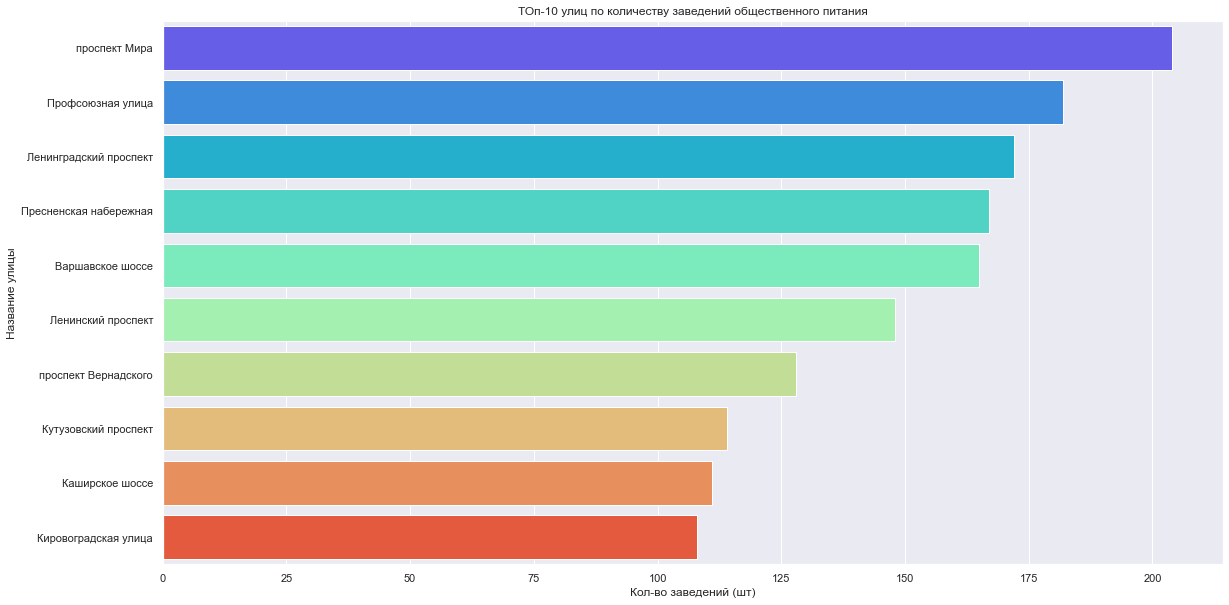

In [31]:
# построим график
sns.barplot(x='rest_cnt', y='street', data=top_street, palette='rainbow')
plt.title('ТОп-10 улиц по количеству заведений общественного питания')
plt.ylabel('Название улицы')
plt.xlabel('Кол-во заведений (шт)')

In [32]:
one_rest = (rest_geo
            .groupby('street')
            .agg({'id':'count', 'district':'max'})
            .query('id == 1')
            .reset_index())

one_rest.columns = ['street', 'rest_cnt', 'district']

Text(0.5, 0, 'Название района')

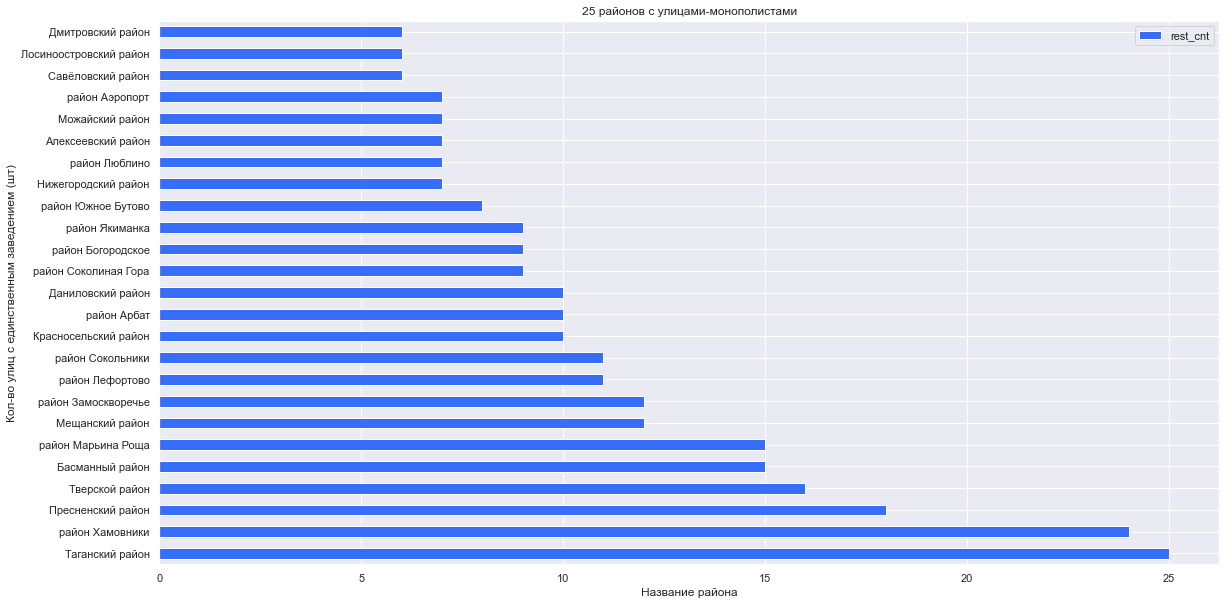

In [33]:
(one_rest
 .groupby('district')
 .agg({'rest_cnt':'sum'})
 .reset_index()
 .sort_values(by='rest_cnt', ascending=False)
 .head(25)
 .plot(x='district', y='rest_cnt', kind='barh'))

plt.title('25 районов с улицами-монополистами')
plt.ylabel('Кол-во улиц с единственным заведением (шт)')
plt.xlabel('Название района')

In [34]:
# кол-во районов с улицами-монополистами
(one_rest
 .groupby('district')
 .agg({'rest_cnt':'sum'})
 ['rest_cnt']
 .count())

120

In [35]:
# кол-во улиц-монополистов
one_rest['street'].count()

532

В некоторых районах есть улицы, на которых представлено всего одно заведение общественного питания — таких оказалось 120 (мы не учитывали отброшенные ранее мелкие населенные пункты, в которых такое явление скорее норма). На графике видно топ-25 районов, где таких улиц-монополистов больше всего. В 13 районах от 25 до 10 таких улиц, среди них наиболее крупные по количеству заведений в целом: Пресненский район, Мещанский район.  
  
Изучим распределение количества посадочных мест для улиц с наибольшим количеством заведений.

In [36]:
# срез по популярным улицам
top_street_dict = list(top_street['street'])
seat = rest_geo.query('street in @top_street_dict').drop(columns=['address', 'house']).reset_index(drop=True)
seat.head(3)

,id,object_name,chain,object_type,number,street,district
0,155973,Кафе «Андерсон»,да,кафе,150,Варшавское шоссе,Донской район
1,23618,Кафе «Subway»,да,кафе,36,Варшавское шоссе,Донской район
2,155852,Кафе «Ламаджо»,нет,кафе,30,Варшавское шоссе,Донской район


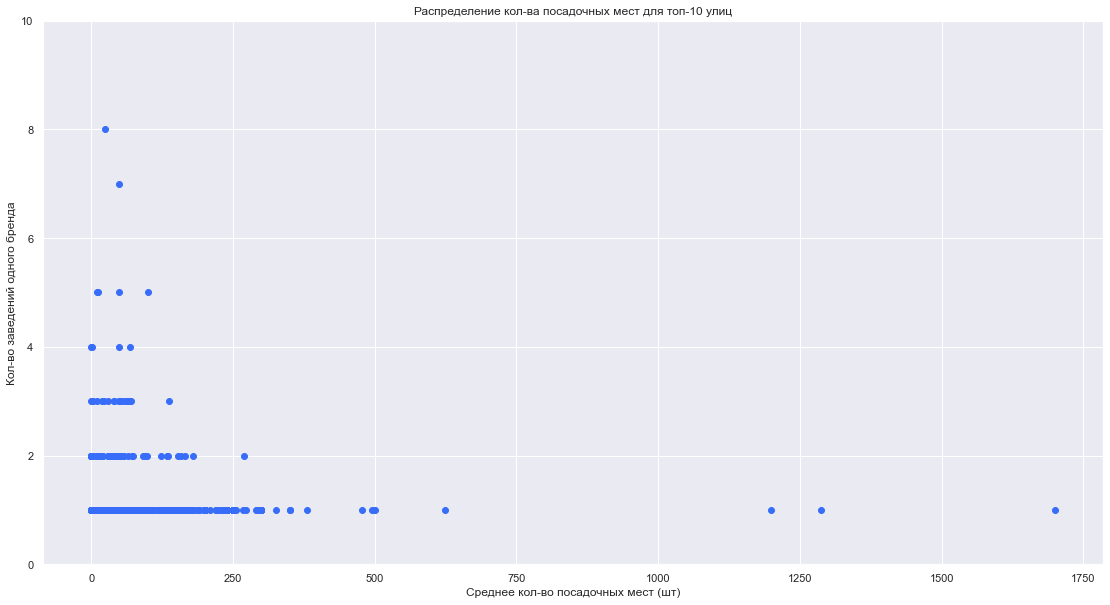

In [37]:
# визуализируем распределение кол-ва посадочных мест
(seat
 .groupby(['street', 'object_name']).agg({'id':'count', 'number':'median'})
 .plot(x='number', y='id', style='o', ylim=(0, 10)))

plt.title('Распределение кол-ва посадочных мест для топ-10 улиц')
plt.ylabel('Кол-во заведений одного бренда')
plt.xlabel('Среднее кол-во посадочных мест (шт)')
plt.legend().set_visible(False)

На графике выше мы видим распределение заведений по количеству посадочных мест с учетом количества объектов в сети. Для несетевых заведений (один объект) характерно большее разнообразие по количеству посадочных мест, при этом основная масса заведений лежит в пределах 0-200, для сетевых брендов с 2 объектами в сети более характерны объекты на 0-100, а для сетей от 3 заведений реже встречаются объекты в формате "на вынос" (0 мест) и чаще всего помещения до 50 мест.

# Часть 3. Итоговые выводы исследования <a name='3'></a>

Для открытия ресторана с роботизированным обслуживанием наиболее подходит **формат кафе**, так как:  
* он позволяет в будущем масштабироваться за счет открытия сети,  
* позволяет иметь более простое и доступное по цене меню в отличие от ресторана,   
* посетители более лояльны к показателям времени на ожидание заказа в отличие от предприятий быстрого обслуживания,  
* формат кафе также дает свободу в выборе помещения и количесства посадочных мест.

Для старта первого проекта удобнее всего ориентироваться не среднего размера **помещение до 50 посадочных мест** — это более привычные размеры для рынка и реалистичные в рамках проекта, кроме того, в случае открытия дополнительных заведений будет проще поддерживать единый формат и стиль (для сетевых заведений характерен рсчет на 40-50 пасадочных мест).  

В успехе запуска проекта играет роль потенциальная "проходимость" территории, на которой откроется кафе, поэтому стоит обратить внимание на **районы с высокой популярностью по количеству заведений общественного питания.** При этом можно рассматривать как насыщенные зведениями улицы, так и более удаленные от эпицентра по количеству заведений. При выборе стоит обратить внимание на **доступность от метро и удобство навигации**. Высокая конкуренция в данном случае играет скорее положительную роль по двум причинам: проект уникальный и не требует дополнительной "отстройки" от конкурентов, в районах с большой конкуренцией больше спрос и поток посетителей, которые могут заинтересоваться новым кафе с непривычным форматом без дорогой рекламы на привлечение.  

Среди районов, на которые следует **обратить внимание:** Пресненский (Пресненская набережная), Мещанский (Проспект мира), Арбат (Арбатская улица), Тверской (Тверская). Но для окончательного решения необходимо дополнительно проанализировать варианты аренды и их стоимость, возможно, стоит выбрать менее крупный район и перераспределить съэкономленный бюджет в пользу маркетинга.  

*Для будущего развития проекта можно расмотреть модель открытия сети не в рамках одного города, а масштабирование за счет открытия в других крупных городах, где формат роботизированного заведения будет уникальным явлением на рынке и привлечет больше внимания.*  

[*Презентацию исследования можно изучить по ссылке*](https://yadi.sk/i/z5kfb8PeVh7_Mw)

____
**<center>[Перейти в начало исследования](#0)</center>**